In [246]:
# import libraries
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset,Subset
import copy
from sklearn.model_selection import train_test_split
from skimage.draw import line_aa

# for importing data
import torchvision
import torchvision.transforms as T

import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

C:\Users\lucan\AppData\Local\Temp\ipykernel_14948\245622201.py:18: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


In [247]:
# use GPU if available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


# Generate train and dev data

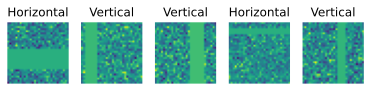

In [248]:
# 1x30x30 images of gaussian noise plus a horizontal or vertical bar

N: int = 10000
image_width: int = 30
bar_max_width: int = 10
images = np.random.randn(N, image_width, image_width)

# Random directions (horizontal = 0, vertical = 1)
labels = np.append(np.ones(N // 2), np.zeros(N // 2)).astype(int)
np.random.shuffle(labels)
# labels = (np.random.randn(N) > 0.5).astype(int)
label_to_name = {0: "Horizontal", 1: "Vertical"}

# Add the bar with random direction
for idx in range(N):
    slope = labels[idx]

    # Random start index from 1 to 27 with a random width of 1-10
    bar_start = np.random.randint(1, image_width - 2)
    bar_width = np.random.randint(2, bar_max_width + 1)

    if slope:
        images[idx, :, bar_start:bar_start+bar_width] = 1
    else:
        images[idx, bar_start:bar_start+bar_width, :] = 1

plt.figure()

for i in range(5):
    plt.subplot(151 + i)
    plt.imshow(images[i, :, :])
    plt.title(f"{label_to_name[labels[i]]}")
    plt.axis(False)

plt.show()

In [249]:
# Split into train and dev-set
N_devset: int = int(N * 0.1)
devset_images = images[:N_devset, :, :]
devset_labels = labels[:N_devset]
train_images = images[N_devset:, :, :]
train_labels = labels[N_devset:]

# Generate test data

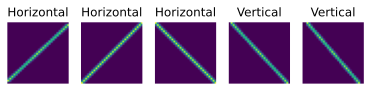

In [250]:
# 1x30x30 images of gaussian noise plus a bar with a slope between [-30, 30]
testset_images  = np.zeros((2*image_width, image_width, image_width))
testset_labels  = np.zeros(2*image_width)
slopes          = np.zeros(2*image_width)

for i in range(image_width):
    ### create lines with |slope|<1
    # point coords
    p1 = [0,i]
    p2 = [image_width-p1[0]-1,image_width-p1[1]-1]
    slopes[i] = (p2[1]-p1[1])/(p2[0]-p1[0]+1e-10)

    # create the lines
    rows,cols,val = line_aa(p1[1],p1[0],p2[1],p2[0]) #  y1,x1,y2,x2
    testset_images[i,rows,cols] = val

    ### create lines with |slope|>1
    # point coords
    p1 = [i,0]
    p2 = [image_width-p1[0]-1,image_width-p1[1]-1]
    slopes[i+image_width] = (p2[1]-p1[1])/(p2[0]-p1[0]+1e-10)

    # create the lines
    rows,cols,val = line_aa(p1[1],p1[0],p2[1],p2[0]) #  y1,x1,y2,x2
    testset_images[i+image_width,rows,cols] = val

testset_labels = (np.abs(slopes) > 1).astype(int)

plt.figure()

for i in range(5):
    plt.subplot(151 + i)

    # Make sure we have a bit of both
    i += image_width - 2

    plt.imshow(testset_images[i, :, :])
    plt.title(f"{label_to_name[testset_labels[i]]}")
    plt.axis(False)

plt.show()

In [251]:
# Check the data parameters
print(f"[{train_images.shape}] images and [{len(train_labels)}] in training set")
print(f"[{devset_images.shape}] images and [{len(devset_labels)}] in devset")
print(f"[{testset_images.shape}] images and [{len(testset_labels)}] in testing set")

print(np.unique(train_labels, return_counts=True))
print(np.unique(devset_labels, return_counts=True))
print(np.unique(testset_labels, return_counts=True))

[(9000, 30, 30)] images and [9000] in training set
[(1000, 30, 30)] images and [1000] in devset
[(60, 30, 30)] images and [60] in testing set
(array([0, 1]), array([4508, 4492], dtype=int64))
(array([0, 1]), array([492, 508], dtype=int64))
(array([0, 1]), array([31, 29], dtype=int64))


# Create dataloaders

In [252]:
# transform data to pytorch layout
train_imagesT   = torch.tensor(train_images.reshape((train_images.shape[0], 1, image_width, image_width))).float()
devset_imagesT  = torch.tensor(devset_images.reshape((devset_images.shape[0], 1, image_width, image_width))).float()
testset_imagesT = torch.tensor(testset_images.reshape((testset_images.shape[0], 1, image_width, image_width))).float()

train_labelsT = torch.tensor(np.vstack(train_labels)).float()
devset_labelsT = torch.tensor(np.vstack(devset_labels)).float()
testset_labelsT = torch.tensor(np.vstack(testset_labels)).float()

# Convert to pytorch datasets
train_dataset = TensorDataset(train_imagesT, train_labelsT)
dev_dataset   = TensorDataset(devset_imagesT, devset_labelsT)
test_dataset  = TensorDataset(testset_imagesT, testset_labelsT)

# Translate into dataloader objects
batchsize    = 32
train_loader = DataLoader(train_dataset, batch_size=batchsize, shuffle=True, drop_last=True)
dev_loader   = DataLoader(dev_dataset, batch_size=len(dev_dataset))
test_loader  = DataLoader(test_dataset, batch_size=len(test_dataset))

# Create CNN

In [354]:
def get_conv_layer_output_size(input_size: (int, int), padding: (int, int), kernel_size: (int, int), stride: (int, int), pool_size: (int, int)) -> (int, int):
    dim0 = int((((input_size[0] + (2 * padding[0]) - kernel_size[0]) / stride[0]) + 1) / pool_size[0])
    dim1 = int((((input_size[1] + (2 * padding[1]) - kernel_size[1]) / stride[1]) + 1) / pool_size[1])
    return dim0, dim1


class MyBarCNN(nn.Module):
    def __init__(self,printtoggle):
        super().__init__()

        # print toggle
        self.print = printtoggle

        ### -------------- feature map layers -------------- ###
        # first convolution layer
        self.conv1  = nn.Conv2d(1,16,3,padding=1)
        self.conv1_output = get_conv_layer_output_size((image_width, image_width), self.conv1.padding, self.conv1.kernel_size, self.conv1.stride, (2,2))
        if self.print: print(f"conv1 layer output: {self.conv1_output}")

        # second convolution layer
        self.conv2  = nn.Conv2d(16,32,3,padding=1)
        self.conv2_output = get_conv_layer_output_size(self.conv1_output, self.conv2.padding, self.conv2.kernel_size, self.conv2.stride, (2,2))
        if self.print: print(f"conv2 layer output: {self.conv2_output}")

        ### -------------- linear decision layers -------------- ###
        self.fc1 = nn.Linear(self.conv2_output[0]*self.conv2_output[1]*self.conv2.out_channels, 64)
        self.fc2 = nn.Linear(64, 1)

    def forward(self,x):
        x = F.max_pool2d(self.conv1(x),2)
        x = F.relu(x)
        x = F.dropout(x, p=0.25, training=self.training)

        x = F.max_pool2d(self.conv2(x),2)
        x = F.relu(x)
        x = F.dropout(x, p=0.25, training=self.training)

        # reshape for linear layer
        nUnits = x.shape.numel()/x.shape[0]
        x = x.view(-1,int(nUnits))

        # linear layers
        x = F.relu(self.fc1(x))
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.fc2(x)
        return x

def create_the_net(print: bool = False):
    # create the model instance and copy to device (GPU)
    net = MyBarCNN(print).to(device)

    # loss function
    lossfun = nn.BCEWithLogitsLoss()

    # optimizer
    optimizer = torch.optim.Adam(net.parameters(), lr=.001, weight_decay=0.001)

    return net,lossfun,optimizer

In [355]:
# test the model with one batch
net,lossfun,optimizer = create_the_net(True)

X,y = next(iter(train_loader))
yHat = net(X.to(device)).cpu()

# check size of output
print('\nOutput size:')
print(yHat.shape)
print(y.shape)

# now let's compute the loss
loss = lossfun(yHat,y)
print(' ')
print('Loss:')
print(loss)

conv1 layer output: (15, 15)
conv2 layer output: (7, 7)

Output size:
torch.Size([32, 1])
torch.Size([32, 1])
 
Loss:
tensor(0.6825, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


# Function to train the model

In [356]:
# a function that trains the model
def function2trainTheModel(net=None):

    # number of epochs
    numepochs = 10

    numbatches = len(list(train_loader))

    # create a new model, or use exisiting net
    net_,lossfun,optimizer = create_the_net()
    if net is None:
        net = net_

    # initialize losses
    trainLoss = torch.zeros(numepochs)
    devLoss  = torch.zeros(numepochs)
    trainAcc  = torch.zeros(numepochs)
    devAcc   = torch.zeros(numepochs)

    # loop over epochs
    for epochi in range(numepochs):
        print(f"Starting epoch {epochi}...")

        # loop over training data batches
        net.train()
        batchLoss = torch.zeros(numbatches)
        batchAcc  = torch.zeros(numbatches)
        batch_idx = 0
        for X,y in train_loader:
            X = X.to(device)
            y = y.to(device)

            # forward pass and loss
            yHat = net(X)
            loss = lossfun(yHat, y)

            # backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # loss and Accuracy from this batch
            batchLoss[batch_idx] = loss
            batchAcc[batch_idx] = torch.mean(((yHat > 0).int() == y).float())
            batch_idx += 1
        # end of batch loop...

        # and get average losses and accuracies rates across the batches
        trainLoss[epochi] = torch.mean(batchLoss)
        trainAcc[epochi]  = 100*torch.mean(batchAcc)

        ### dev performance
        net.eval()
        X,y = next(iter(dev_loader)) # extract X,y from test dataloader
        X = X.to(device)
        y = y.to(device)
        with torch.no_grad(): # deactivates autograd
            yHat = net(X)
            loss = lossfun(yHat, y)

        # get loss and accuracy rate from the devset
        devLoss[epochi] = loss
        devAcc[epochi]  = 100*torch.mean(((yHat > 0).int() == y).float())

        print(f"Training... Epoch [{epochi+1}/{numepochs}] done. Accuracy: {devAcc[epochi]:.02f}%")

    # end epochs

    # function output
    return trainLoss,devLoss,trainAcc,devAcc,net

# Train the model

In [357]:
trainLoss,devLoss,trainAcc,devAcc,net = function2trainTheModel()

Starting epoch 0...
Training... Epoch [1/10] done. Accuracy: 99.90%
Starting epoch 1...
Training... Epoch [2/10] done. Accuracy: 100.00%
Starting epoch 2...
Training... Epoch [3/10] done. Accuracy: 100.00%
Starting epoch 3...
Training... Epoch [4/10] done. Accuracy: 100.00%
Starting epoch 4...
Training... Epoch [5/10] done. Accuracy: 100.00%
Starting epoch 5...
Training... Epoch [6/10] done. Accuracy: 100.00%
Starting epoch 6...
Training... Epoch [7/10] done. Accuracy: 100.00%
Starting epoch 7...
Training... Epoch [8/10] done. Accuracy: 100.00%
Starting epoch 8...
Training... Epoch [9/10] done. Accuracy: 100.00%
Starting epoch 9...
Training... Epoch [10/10] done. Accuracy: 100.00%


In [358]:
# # Transfer learning, if required
# trainLoss_,devLoss_,trainAcc_,devAcc_, net = function2trainTheModel(net)
#
# # Concatenate data
# trainLoss = torch.cat((trainLoss, trainLoss_))
# devLoss = torch.cat((devLoss, devLoss_))
# trainAcc = torch.cat((trainAcc, trainAcc_))
# devAcc = torch.cat((devAcc, devAcc_))

# Evaluate test set

In [359]:
net.eval()
X, y = next(iter(test_loader))
yHat = net.cpu()(X)
testAcc = 100 * torch.mean(((yHat > 0).int() == y).float())
print(f"Testset accuracy: {testAcc:.3f}%")

Testset accuracy: 91.667%


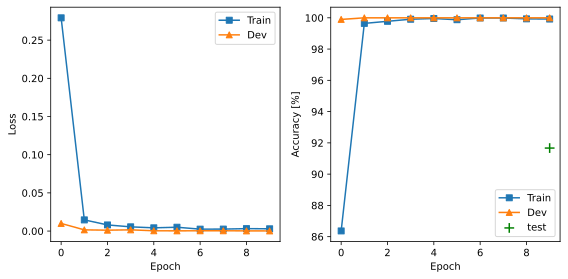

In [360]:
plt.figure(figsize=(8, 4))

plt.subplot(121)
plt.plot(trainLoss.detach(), 's-', label="Train")
plt.plot(devLoss.detach(), '^-', label="Dev")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.subplot(122)
plt.plot(trainAcc.detach(), 's-', label="Train")
plt.plot(devAcc.detach(), '^-', label="Dev")
plt.scatter(len(trainAcc.detach()) - 1, testAcc, marker='+', label="test", color="green", s=96)

plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Accuracy [%]")

plt.tight_layout()
plt.show()

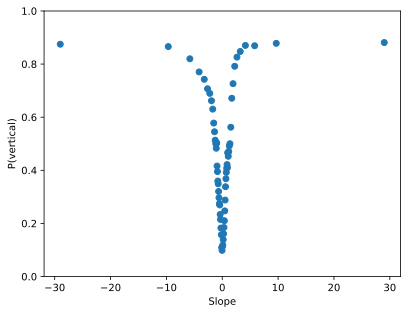

In [361]:
p = torch.sigmoid(yHat).detach().numpy().flatten()

plt.figure()

plt.scatter(slopes, p)
plt.xlabel("Slope")
plt.ylabel("P(vertical)")

plt.ylim(0, 1)

plt.show()